## Data analysis on interaction data with new employees 
- This is a data analysis report pertaining to the data examination phase of a project focusing on Organizational Management.
- Work by Mian LI.

In [31]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
from datetime import datetime

In [32]:
# read data
interactions_df = pd.read_stata("interactions.dta")
attributes_df = pd.read_stata("attributes.dta")

### Visualizing Dynamic Changes in Employee Document Interactions

#### Relationship Network Visualization Based on Weighted Sum of Document Reading, Editing, Commenting, and Favoriting. 
The strength of collaboration between two employees is measured by the weighted sum of document reading, editing, commenting, and favoriting. The reciprocal of the strength measures the proximity of collaboration between two employees, represented in a relationship network diagram.

Using document interaction data rather than:

- Chat interaction data: New employees tend to communicate more with HR and IT department employees initially, which may blur the analysis results of work collaboration.
- Meeting interaction data: New employees participate in more meetings to familiarize themselves with work and colleagues' responsibilities, but meeting content may not directly relate to work.

#### Data Processing Steps:

#### 1.	Selecting data records of employees hired after a certain date to obtain behavioral data of new employees. The specific method involves merging the weekly interaction relationship table and the static employee attribute table, and retaining data with hire dates (last_hire_date) later than the earliest data record date ('2021-01-10').

- Since variables in both emp_a and emp_b tables indicate the data relationship as "Employee A's document/OKR being read/commented by Employee B...", there is no distinction in handling the subject-object relationships of A and B in the two tables. They are directly appended and merged. This point may be misunderstood.

In [33]:
# merge two datasets
clean_int_df = pd.merge(interactions_df, attributes_df, left_on='emp_a', right_on='staffkey', how='left')

# filter out new employees
record_start_date = clean_int_df['date'].min()
clean_int_df = clean_int_df[clean_int_df['last_hire_date'] > record_start_date]

#clean_int_df
#record_start_date

In [34]:
# commpute intensity of interactions
clean_int_df['relationship_strength'] =  1 * clean_int_df['read_num'] + \
    3 * clean_int_df['edit_num'] + 2 * clean_int_df['comment_num'] + 2 * clean_int_df['favorite_num']

# clear out nodes with no edge
clean_int_df = clean_int_df[clean_int_df['relationship_strength'] != 0]

#clean_int_df['date']
#clean_int_df.to_csv('clean_int.csv', index=False)

#### 2. Using the networkx package for plotting.

In [35]:
# sort out connection dictionary
def find_all_connections(emp, dt, df):
    '''
    Find all connections of a certain empolyee on a certain date
    '''
    emp_df = df[(df['emp_a'] == emp) & (df['date'] == dt)]
    connections = {}
    sum = 0
    for _, row in emp_df.iterrows():
        length = 1/row['relationship_strength']
        if row['emp_a'] not in connections:
            connections[row['emp_a']] = [(row['emp_b'], length)]
            sum += 1
        else:
            connections[row['emp_a']].append((row['emp_b'], length))
            sum += 1
    return (connections,sum)

In [36]:
file_path = 'figures/'

In [37]:
# draw network graph of connections

def convert_to_readable_string(long_key):
    # Use SHA-256 hash function
    sha256_hash = hashlib.sha256(long_key.encode()).hexdigest()
    return sha256_hash[:8]  # Use the first 8 characters for readability

def draw_graph(emp, dt, connections):
    G = nx.DiGraph()
    for a,v in connections.items():
        for (b, strength) in v:
            G.add_edge(a,b, length = strength)
    
    edge_labels = {(a, b): '%.2f' % data.get('length', 0) for (a, b, data) in G.edges(data=True)}
    pos = nx.spring_layout(G)
    node_labels = {node: convert_to_readable_string(node) for node in G.nodes()}

    nx.draw(G, pos, with_labels=True, labels=node_labels, font_size=8, font_color='black', node_size=300,
            edge_color='gray', alpha=0.7, width=[d['length'] for (u, v, d) in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    readble_string = convert_to_readable_string(emp)
    plt.savefig(file_path + "%s - %s.png" % (readble_string, dt), format="png")
    plt.clf()

In [38]:
# all new employees
new_emp = set(clean_int_df['emp_a'])
len(new_emp)

30

In [39]:
# summarize and visualization

n_emp_by_dt = 0
m_emp_by_dt_by_connections = 0

for emp in new_emp:
    # sort by date
    dts = set(clean_int_df['date'])
    for dt in dts:
        (connections, m) = find_all_connections(emp, dt, clean_int_df)
        draw_graph(emp, dt, connections)

        n_emp_by_dt += 1
        m_emp_by_dt_by_connections += m

(n_emp_by_dt, m_emp_by_dt_by_connections)

(60, 193)

<Figure size 640x480 with 0 Axes>

#### Results: Long-term data changes cannot be observed from the small sample (most employees only have data for 1 or 2 days); and due to the small sample, the current statistics are done on a daily basis, resulting in large fluctuations that do not reflect interpretable changes. Statistics on a weekly or monthly basis would be better.

- Number of employees: 30, Number of employee dates: 60, Number of employee dates and relationships: 193

### Reflecting the Supervisory Guidance Mode and Changes through OKR Interaction

Definition:

- Attention: The sum of reading, liking, and commenting on OKRs and weekly reports.
- Direct management level: The sum of OKR at and at reply numbers. Since OKR at and at replies usually occur when superiors need employees to fill in or modify OKRs, it is an indication of more direct managerial involvement by superiors.


The image of changes in attention and direct management level (average of total samples) with the entry time of new employees intuitively shows the changes in the interaction mode with superiors after new employees join.

In [40]:
clean_int_df['occupation_period'] = pd.to_timedelta('0 days')

for index, row in clean_int_df[:5].iterrows():
    last_hire_date = datetime.strptime(row['last_hire_date'], '%Y-%m-%d')
    current_date = datetime.strptime(row['date'], '%Y-%m-%d')
    clean_int_df.at[index, 'occupation_period'] = (current_date - last_hire_date)

#clean_int_df['occupation_period'].dt.total_seconds() / (24 * 60 * 60)
sorted_df = clean_int_df.sort_values(by='occupation_period')
#sorted_df['occupation_period']
#sorted_df.to_csv('sorted.csv', index=False)

In [41]:
sorted_df['attention'] = (sorted_df['num_okr_like'] + sorted_df['num_okr_comment'] 
                              + sorted_df['num_okr_visitors'] + sorted_df['num_weekly_like']
                              +sorted_df['num_weekly_read'] +sorted_df['num_weekly_comment'])
sorted_df['okr_manage'] = sorted_df['num_okr_at'] + sorted_df['num_okr_ated']

In [42]:
average_by_period = sorted_df.groupby('occupation_period')['attention'].mean()
average_by_period.index

TimedeltaIndex(['0 days', '83 days'], dtype='timedelta64[ns]', name='occupation_period', freq=None)

occupation_period
0 days     0.037234
83 days    0.000000
Name: attention, dtype: float64


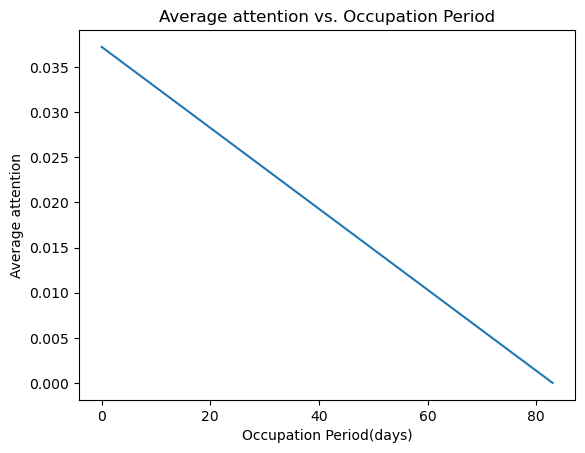

In [43]:
# The style of direct leadership management of new employees in this company
average_attention_by_period = sorted_df.groupby('occupation_period')['attention'].mean()
print(average_attention_by_period)
# Plotting
plt.plot(average_attention_by_period.index.days, average_attention_by_period.values)
plt.xlabel('Occupation Period(days)')
plt.ylabel('Average attention')
plt.title('Average attention vs. Occupation Period')
plt.savefig(file_path +'average_okr_attention_plot.png')
plt.show()

occupation_period
0 days     0.026596
83 days    0.000000
Name: okr_manage, dtype: float64


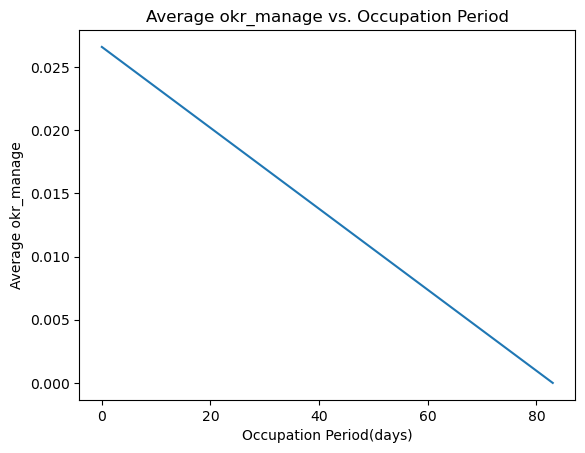

In [44]:
average_manage_by_period = sorted_df.groupby('occupation_period')['okr_manage'].mean()
print(average_manage_by_period)
# Plotting
plt.plot(average_manage_by_period.index.days, average_manage_by_period.values)
plt.xlabel('Occupation Period(days)')
plt.ylabel('Average okr_manage')
plt.title('Average okr_manage vs. Occupation Period')
plt.savefig(file_path + 'average_okr_manage_plot.png')
plt.show()

From the above graph, we can see that:

1. Both attention and direct management level decrease with entry time.

Note:

1. OKR interaction data cannot reflect offline communication, so it cannot fully reflect employees' work patterns.
2. Due to the small sample size, some OKR data only have data for 0 or 83 days after entry, and cannot accurately reflect trends.

### Changes in the Number of Meeting Participants

This part aims to observe changes in the number of cooperation partners after employees join.

Define document editing (edit_num), meetings (meet_num), and sharing (num_shedule_share) as cooperative behaviors. Anyone with an index greater than 1 is considered a collaborator with employee emp_a. Count the total number of such people on a daily basis to observe changes in the number of collaborators after new employees join.

occupation_period
0 days     1.037234
83 days    0.200000
Name: cooperation, dtype: float64


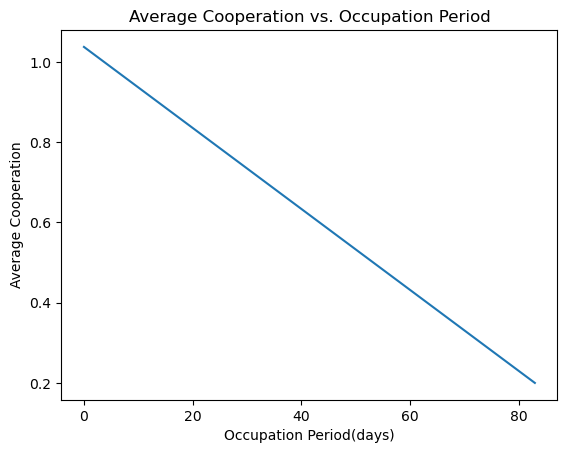

In [45]:
sorted_df['cooperation'] = sorted_df['meet_num'] + sorted_df['num_shedule_share']
average_coop_by_period = sorted_df.groupby('occupation_period')['cooperation'].mean()
print(average_coop_by_period)
# Plotting
plt.plot(average_coop_by_period.index.days, average_coop_by_period.values)
plt.xlabel('Occupation Period(days)')
plt.ylabel('Average Cooperation')
plt.title('Average Cooperation vs. Occupation Period')
plt.savefig(file_path + 'average_Cooperation_plot.png')
plt.show()

In [46]:
individual_coop = {}

new_emp_set = set(sorted_df['emp_a'])

for _, row in sorted_df.iterrows():
    emp = row['emp_a']
    period = row['occupation_period']
    if emp not in individual_coop:
        individual_coop[emp] = {}
        if (row['meet_num'] > 0 or row['num_shedule_share'] > 0 or row['edit_num'] > 0):
            individual_coop[emp][period] = 1
        else:
            individual_coop[emp][period] = 0
    else:
        if (row['meet_num'] > 0 or row['num_shedule_share'] > 0 or row['edit_num'] > 0):
            if period not in individual_coop[emp]:
                individual_coop[emp][period] = 1
            else:
                individual_coop[emp][period] += 1

plot_dtc = {}
for emp, coop in individual_coop.items():
    if len(coop) > 1:
        plot_dtc[emp] = coop

plot_dtc.values()

dict_values([{Timedelta('0 days 00:00:00'): 24, Timedelta('83 days 00:00:00'): 3}])

{Timedelta('0 days 00:00:00'): 24, Timedelta('83 days 00:00:00'): 3}


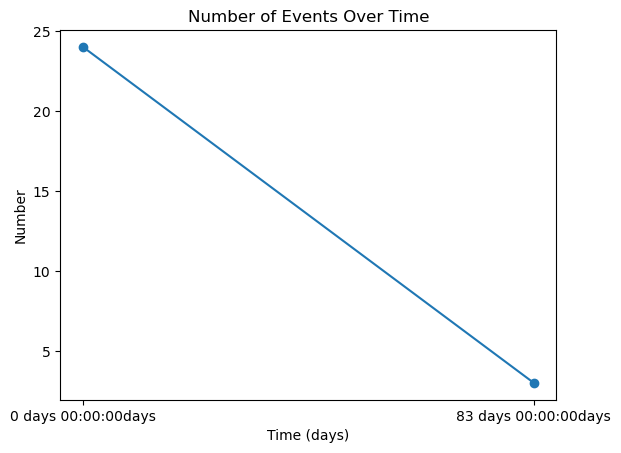

In [47]:
# Plot
for emp, emp_coop in plot_dtc.items():
    print(emp_coop)
    keys_in_days = [key for key in emp_coop.keys()]

    plt.plot([str(time) + 'days' for time in keys_in_days], emp_coop.values(), marker='o')
    plt.xlabel('Time (days)')
    plt.ylabel('Number')
    plt.title('Number of Events Over Time')

    plt.savefig(file_path + 'cooperation_plot.png')
    plt.show()

It can be seen that the number of collaborators decreases after new employees join.